# Model definition
This notebook aims to develop and evaluate a model to predict diamond prices given data in the proposed format ([diamond dataset](datasets/diamonds/README.md)). A special effort is made to build a clean reusable pipeline for the model. Moreover, interpretability and scalability considerations are made.

In [1]:
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import PartialDependenceDisplay
from matplotlib import pyplot as plt

from diamond import data
from diamond import model

Data is loaded, cleaned and split as previously defined during [data exploration](data_exploration.ipynb).

In [2]:
X_train, X_test, y_train, y_test = data.split(
    *data.get_X_y(data.clean(data.load_raw('datasets/diamonds/diamonds.csv'))))

All transformations and feature extractions steps defined during data exploration are here consolidated into a single pipeline, which includes:

* Ordinal encoding of sequential data types: *cut*, *color*, *clarity*
* Extraction of new features, namely: *volume*, *eccentricity*, *table distance*, *depth distance*
* Log transformation of long tailed features: *x*, *y*, *z*, *volume* *carat*
* Standard scaling of all features (centering and rescaling by standard deviation)
* Feature selection (more on this later)

Finally, the data is fed to a linear regression model. The target variable *price* is also log transformed, so that the internal model will learn to predict the log of the price, consistently with the log transformation over *volume*, *carat*, etc.

A linear model was chosen for its bare bones interpretability. Moreover, a very high linear correlation was discovered between the diamond price and some of the input during data exploration, suggesting that a linear model is a fair fit for the problem.

In [3]:
model.pipeline

Pipeline(steps=[('encoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder-1',
                                                  OrdinalEncoder(categories=[['Poor',
                                                                              'Fair',
                                                                              'Good',
                                                                              'Very '
                                                                              'Good',
                                                                              'Premium',
                                                                              'Ideal']],
                                                                 dtype=<class 'numpy.float32'>),
                                                  ['cut']),
                                                 ('ordinalencoder-2',
                                                  OrdinalEncoder(categories=[['Z',
                                                                              'Y',
                                                                              'X',
                                                                              'W',
                                                                              'V',
                                                                              'U',
                                                                              'T',
                                                                              'S',
                                                                              'R',
                                                                              'Q',
                                                                              'P',
                                                                              'O',
                                                                              'N',
                                                                              'M',
                                                                              'L',
                                                                              'K',
                                                                              'J',
                                                                              'I',
                                                                              'H',
                                                                              'G...
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('functiontransformer',
                                                  FunctionTransformer(func=<ufunc 'log'>,
                                                                      inverse_func=<ufunc 'exp'>),
                                                  ['x', 'y', 'z', 'volume',
                                                   'carat'])],
                                   verbose_feature_names_out=False)),
                ('scaler', StandardScaler()), ('selector', 'passthrough'),
                ('linear',
                 TransformedTargetRegressor(func=<ufunc 'log'>,
                                            inverse_func=<ufunc 'exp'>,
                                            regressor=LinearRegression()))])

## Model tuning and feature selection

The last step in the data pipeline is a feature selection step. Since we added a variety of new features, it is crucial to select only the really informative ones in order to ensure simple human interpretability of the final model. Moreover, data exploration suggested *strong collinearity* between various features, in particular *carat* and the absolute measures *x*, *y*, *z* (including the newly extracted *volume*). Strong collinearity is a potential harm to the overall explainability of the model coefficients, due to the linear dependency between features.

For these reasons, feature selection is performed partially in a manual fashion, hand picking feature sets that minimize collinearity and that preserve simple interpretability. Different feature sets are hand picked and then automatically evaluated using a grid search with cross validation.

In [4]:
parameter_grid = model.make_params(model.DEFAULT_USER_PARAMETER_GRID)
print('Feature sets')
model.DEFAULT_USER_PARAMETER_GRID['selector']

Feature sets


(('carat',),
 ('volume',),
 ('carat', 'cut', 'color', 'clarity'),
 ('carat', 'cut', 'color', 'clarity', 'eccentricity'),
 ('volume', 'cut', 'color', 'clarity'),
 ('volume', 'cut', 'color', 'clarity', 'eccentricity'),
 ('carat', 'table', 'depth_distance', 'eccentricity', 'color', 'clarity'),
 ('volume', 'table', 'depth_distance', 'eccentricity', 'color', 'clarity'))

Most of the selected feature sets include the 4Cs, as they are probably the most well known diamond grading parameters. Given the strong correlation between *volume* and *carat*, they are eventually swapped but never present at the same time. Other absolute measures are never included, as they are considered condensed within *volume*. *cut* is eventually swapped with proportion parameters which have a strong correlation with it (*table*, *depth_distance*, *eccentricity*).

Each selector is evaluated through 5-fold cross validation, using R2 as scoring index. Instead of blindly settling with the best scoring setup, we will make some considerations on the tradeoff between interpretability and performance.

In order to provide extra interpretability, it would be desirable if the model could have positive only coefficients. Given that the 4Cs can be seen as scales representing the "quality" of the gem, it makes sense to express the value of the gem as a direct consequence of them. Clearly, the same cannot be said of other features, such as defects (eccentricity, table distance, etc.) which can naturally be seen as detractors for the final gem value.

In [5]:
parameter_grid = (
    parameter_grid | {'linear__regressor__positive': (True, False)})

search = GridSearchCV(model.pipeline, scoring='r2', param_grid=parameter_grid,
                      refit=True, return_train_score=True)
search.fit(X_train, y_train)
print('Best test R2:', search.best_score_,
      'On a train R2 of:', search.cv_results_['mean_train_score']
                                             [search.best_index_],
      'Achieved with params:', search.best_params_, sep='\n')

Best test R2:
0.9437080963936838
On a train R2 of:
0.9436746258799429
Achieved with params:
{'linear__regressor__positive': False, 'selector': ColumnTransformer(transformers=[('passthrough', 'passthrough',
                                 ('carat', 'table', 'depth_distance',
                                  'eccentricity', 'color', 'clarity'))],
                  verbose_feature_names_out=False)}


Best performance is achieved with a setup using the 4Cs, but the cut grade is replaced with finer properties: *table*, *depth_distance*, *eccentricity*.

In [6]:
pd.DataFrame(
    {'coefficients':
     search.best_estimator_.named_steps['linear'].regressor_.coef_},
    index=search.best_estimator_.named_steps['selector'].transformers[-1][-1])

,coefficients
carat,1.106603
table,-0.005701
depth_distance,-0.028551
eccentricity,-0.005627
color,0.134113
clarity,0.204312


Model coefficients display how the 3Cs have a positive impact on the final price, while *table*, *depth_distance* and *eccentricity* are considered small defects, and indeed make use of negative coefficients. These coefficients give an idea of which property is more important than which, but they cannot be directly interpreted as some of these values undergo log transformations. We will see later some visualization that can help the final user understand the model.

Let's take a deeper look at the grid search results.

In [7]:
# Prettify selectors for visualization
param_selectors = [selector.transformers[-1][-1] for selector
                   in search.cv_results_['param_selector']]
columns = ['mean_test_score', 'mean_train_score',
           'param_linear__regressor__positive', 'param_selector']

cv_results_df = pd.DataFrame(search.cv_results_
                             | {'param_selector': param_selectors})[columns]
cv_results_df

,mean_test_score,mean_train_score,param_linear__regressor__positive,param_selector
0,0.826204,0.826174,True,"(carat,)"
1,0.831069,0.831108,True,"(volume,)"
2,0.943085,0.943003,True,"(carat, cut, color, clarity)"
3,0.943085,0.943003,True,"(carat, cut, color, clarity, eccentricity)"
4,0.941862,0.942024,True,"(volume, cut, color, clarity)"
5,0.941848,0.942024,True,"(volume, cut, color, clarity, eccentricity)"
6,0.939536,0.939361,True,"(carat, table, depth_distance, eccentricity, c..."
7,0.940342,0.940417,True,"(volume, table, depth_distance, eccentricity, ..."
8,0.826204,0.826174,False,"(carat,)"
9,0.831069,0.831108,False,"(volume,)"


The model reaches satisfying results even with a minimal set of input features. The very high correlations that *carat* and *volume* have with the target variable play a big part. In particular, results are competitive even in setups were coefficients are strictly positive.

In [8]:
cv_results_df.iloc[
    cv_results_df.groupby(['param_linear__regressor__positive'])
                 .idxmax(numeric_only=True).mean_test_score]

,mean_test_score,mean_train_score,param_linear__regressor__positive,param_selector
14,0.943708,0.943675,False,"(carat, table, depth_distance, eccentricity, c..."
2,0.943085,0.943003,True,"(carat, cut, color, clarity)"


Inpsecting the best scoring setup for positive only coefficients confirms that it is quite competitive with the overall best setup. Performance is slightly degraded, but interpretability improves dramatically thanks to the model comprising the 4Cs with positive only weights.

This model, from now on called `linear4C-positive`, is the our main proposal to Don Francesco.

## Model interpretation
We fit `linear4C-positive`, observe its coefficients and provide a simple visualization tool that can help Don Francesco and his customers understanding the model's behaviour.

In [9]:
model.pipeline.set_params(
    **model.make_params({'selector': ('carat', 'cut', 'color', 'clarity'),
                         'linear__regressor__positive': True},
                        grid=False))
model.pipeline.fit(X_train, y_train)

# Coefficients
pd.DataFrame(
    {'coefficients':
     model.pipeline.named_steps['linear'].regressor_.coef_},
    index=model.pipeline.named_steps['selector'].transformers[-1][-1])

,coefficients
carat,1.105783
cut,0.035708
color,0.133296
clarity,0.203703


Positive coefficients give a nice idea of the relative importance of the features. The cut grade has a poor impact on the final price of the diamond, despite sometimes being considered the most important C (see data exploration). Once again, since some of the input features are transformed differently, their real relationship with the target variable cannot directly be interpreted by a human customer.

Here we report the partial dependency plot, giving a visual representation of the effect of each feature on the final price.

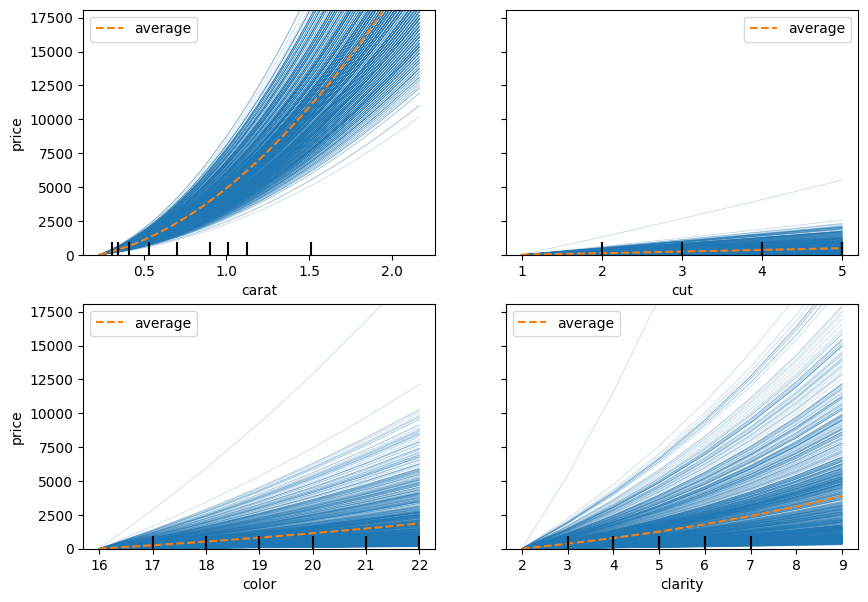

In [10]:
X_trans = data.sequential_encoder.fit_transform(X_train)

_, ax = plt.subplots(figsize=(10, 7))
pdp = PartialDependenceDisplay.from_estimator(
    model.pipeline[1:], X_trans,
    ('carat', 'cut', 'color', 'clarity'),
    kind='both', centered=True, ax=ax,
    percentiles=(0, 0.99),
    n_cols=2, random_state=1)

y_std = y_train.std()
for ax_left, ax_right in pdp.axes_:
    # Set price labels on the left figs, set the same limit to all figs
    ax_left.set_ylabel('price')
    ax_left.set_ylim(0, 4.5 * y_std)
    ax_right.set_ylim(0, 4.5 * y_std)

plt.show()

Here we also report an unbiased estimate of the model's performance, evaluating on a holdout of the original dataset.

In [11]:
print('Holdout R2', model.pipeline.score(X_test, y_test))

Holdout R2 0.9240900025498091
